<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/colabs/dev2vec_in_lkml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIGNAL*ing* `developer activities` in LKML

##### **Copyright 2022 SRI International.**

This project is under the GPL3 License. 
See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

# 🏃‍♀️ Quickstart

Open-source communities strive to evaluate contributed code on its technical correctness and merits. However, these processes are usually loosely supervised and are often influenced by additional factors, including here but not limited to, social rules, trust, reputation, and arcane processes. These additional components lead to unexpected opportunities for subversion. Current approaches, designed to help software development teams to manage the code assessment process, determine the trustworthiness of OSS based on publicly available traces involving code, revision history, logs, and external packages. Although useful, these approaches tend to disregard important inter-and-intra developer interactions that could drastically affect an OSS project's life-cycle.

In this notebook, we introduce a systematic approach and a deep multi-task learning architecture, termed **dev2vec**, for identifying and understanding these developer interactions. We empirically evaluate our approach and deep multi-task learning architecture on the Linux Kernel, a mature ecosystem with a vibrant community and a wealth of socio-technical developer interactions, utilizing conversations and interactions originating from its Linux Kernel Mailing List (LKML). Our approach successfully identifies key developer activities determining the distinct roles developers assume in the LKML.

## &#9776; Install `needed` libraries

In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
# from torchmetrics.functional.classification import accuracy

In [2]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"- Running on: {device}")

- Running on: cpu


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## &#9881; Define `needed` functions

In [4]:
def plot_learning_accuracy(output_list):
  x_axis = list(output_list.keys())
  
  y_triage = list()
  y_bug = list()
  y_controversial = list()

  for k, v in output_list.items():
    y_triage.append(float(v[1]))
    y_bug.append(float(v[2]))
    y_controversial.append(float(v[3]))

  # plottting
  x = x_axis
  fig, ax = plt.subplots()

  line_1, = ax.plot(x, y_triage, label='Triage')
  line_2, = ax.plot(x, y_bug, label='Bugs/Patches')
  line_3, = ax.plot(x, y_controversial, label='Controversial')

  ax.legend()

  plt.show()

## &#129529; Data cleaning and preparation

In [5]:
# data are available locally.
# In Colab mode, this variable should be set to False
IS_LOCAL_FILE = False

In [6]:
ACTIVITIES_FILE = 'activity_triplets_V1_02182022.csv'

In [7]:
# Load preprocessed data and remove unnecessary columns
data_file = f'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/data/{ACTIVITIES_FILE}'

if IS_LOCAL_FILE:
  data_file = f'../data/{ACTIVITIES_FILE}'
else:
  if not os.path.exists(data_file):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy" -O 'activity_triplets_V1_02182022.csv' && rm -rf /tmp/cookies.txt
  else:
    print(f"{ACTIVITIES_FILE} already exists!")

# https://drive.google.com/file/d/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy/view?usp=sharing

--2022-03-28 17:49:54--  https://docs.google.com/uc?export=download&confirm=&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.113, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qpsturrmr35s9tkbl43dpfvnlj35tqs4/1648489725000/12981205944103091625/*/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy?e=download [following]
--2022-03-28 17:49:56--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qpsturrmr35s9tkbl43dpfvnlj35tqs4/1648489725000/12981205944103091625/*/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 74.125.135.132, 2607:f8b0:400e:c01::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-

### &#128202; Load into DataFrame

In order for us to identify relevant questions, we performed frequent itemset mining. To achieve this, we focus on identifying combinations of activities and verify how close those activities are to the **Composite Index**, i.e., how much those activities contribute to the **Composite Index** column in the activities DataFrame.

When considering combinations of two activities, combination 1 corresponding to ('Code Contribution', 'Patch Posting'), is the one providing the most contribution to the composite index. This is an expected behavior in the LKML. However, we are looking also for additional cues that can assist our quest for identifying questions of interest, describing developer actions.

When looking at the combinations of 3 plot, we notice that there are **three** combinations of activities that have significant contributions to the index, namely:

1. **Combination 3:** ('Code Contribution', 'Patch Posting', 'Progress Control'),
2. **Combination 4:** ('Code Contribution', 'Patch Posting', 'Acknowledgement and Response'),
3. **Combination 5:** ('Code Contribution', 'Progress Control', 'Acknowledgement and Response')

Observing the roles extracted in the [activity-roles-detection.ipynb](), we can map the above combination of activities with the **Maintainer**, **Engaged Core Developer**, and **Instigator** role definitions respectively.

Given the roles and the activities considered in the combination triplets, we extract the following 3-questions:

1. Is the next action (taken by a developer) going to be a triage action? **Role 3: Core maintainer**
2. Is the next action (taken by a developer) going to be a small change/bug fix? **Role 2: Engaged core developer**
3. Is the next action (taken by a developer) going to be a controversial change, i.e., spark discussion (a new chain of events)? **Role 4: Instigator**

The DataFrame loaded in the next cells is the outcome of this process!

In [8]:
ACTIVITY_DF = pd.read_csv(f'./{ACTIVITIES_FILE}', sep='\t')

In [9]:
ACTIVITY_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27411 entries, 0 to 27410
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    27411 non-null  int64  
 1   Unnamed: 0.1                  27411 non-null  int64  
 2   Unnamed: 0.1.1                27411 non-null  int64  
 3   sender_id                     27411 non-null  int64  
 4   sent_time                     27411 non-null  object 
 5   Code Contribution             27411 non-null  float64
 6   Knowledge Sharing             27411 non-null  float64
 7   Patch Posting                 27411 non-null  float64
 8   Progress Control              27411 non-null  float64
 9   Acknowledgement and Response  27411 non-null  float64
 10  Composite Index               27411 non-null  float64
 11  Rank                          27411 non-null  float64
 12  Status                        27411 non-null  object 
 13  c

In [10]:
# convert 'sent_time' to pandas datetime64 time format
ACTIVITY_DF['sent_time'] = pd.to_datetime(ACTIVITY_DF['sent_time'], utc=True)

# sort the content of the DataFrame by 'sent_time'
ACTIVITY_DF = ACTIVITY_DF.sort_values(by=['sent_time'])

In [11]:
ACTIVITY_DF.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Composite Index,Rank,comb_2,comb_3,is_triage,is_bug_fix,is_controversial
count,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000
mean,13705.000000,13705.000000,13705.000000,466.761410,0.249106,0.002233,0.106345,0.032836,0.031109,0.421628,13706.000000,1.308270,3.640911,0.492430,0.375835,0.119332
std,7913.018451,7913.018451,7913.018451,535.754602,0.069497,0.006065,0.054297,0.021204,0.015424,0.095375,7913.018451,0.981164,0.856430,0.499952,0.484346,0.324184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042519,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6852.500000,6852.500000,6852.500000,39.000000,0.260254,0.000728,0.062329,0.024287,0.022645,0.375485,6853.500000,1.000000,3.000000,0.000000,0.000000,0.000000
50%,13705.000000,13705.000000,13705.000000,254.000000,0.269938,0.001165,0.126230,0.029335,0.025764,0.449596,13706.000000,1.000000,4.000000,0.000000,0.000000,0.000000
75%,20557.500000,20557.500000,20557.500000,737.000000,0.278295,0.002111,0.153634,0.034573,0.029421,0.486896,20558.500000,1.000000,4.000000,1.000000,1.000000,0.000000
max,27410.000000,27410.000000,27410.000000,2223.000000,0.317105,0.263279,0.176351,0.158647,0.084617,0.695572,27411.000000,9.000000,9.000000,1.000000,1.000000,1.000000


In [12]:
ACTIVITY_DF.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,sent_time,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,...,comb_2,comb_3,is_triage,is_bug_fix,is_controversial,activity_label,project_thread,sendername_thread,triplet_one,triplet_two
24091,24091,24091,24091,0,2020-08-20 09:35:52+00:00,0.262744,0.002416,0.000969,0.032951,0.022704,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
24807,24807,24807,24807,0,2020-08-20 09:35:55+00:00,0.243353,0.001691,0.000833,0.028051,0.021198,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
22403,22403,22403,22403,0,2020-08-20 09:36:02+00:00,0.283699,0.000956,0.000653,0.036240,0.022395,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
24838,24838,24838,24838,0,2020-08-20 09:36:06+00:00,0.249099,0.000994,0.000669,0.014546,0.022657,...,3,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
23953,23953,23953,23953,0,2020-08-20 09:36:09+00:00,0.282001,0.001464,0.000143,0.016604,0.023747,...,3,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown


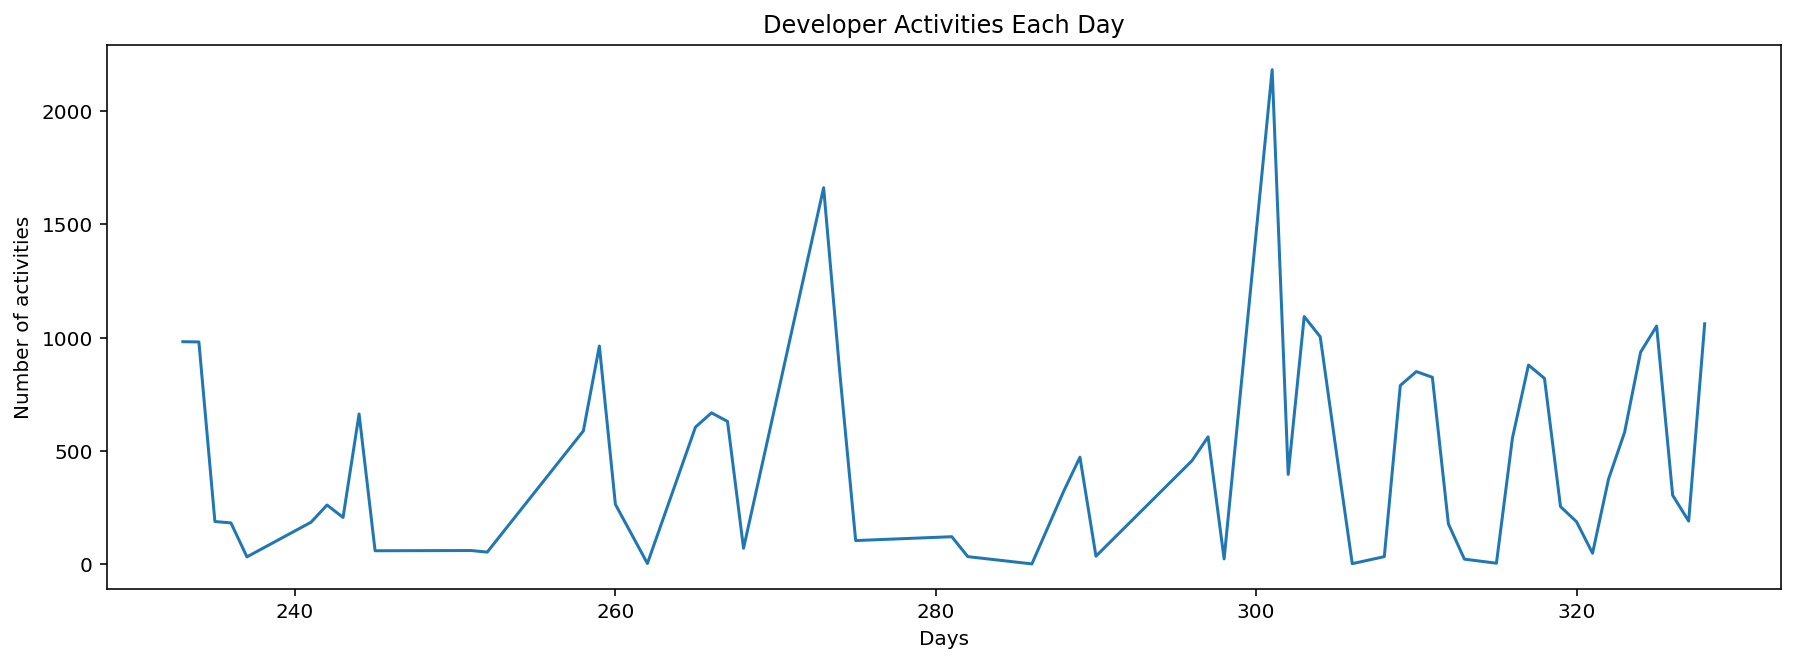

In [13]:
# Plot (visualize) the total number of activities occurring during each day in the August, 2020 - November, 2020 period
tmp_day = ACTIVITY_DF.groupby(ACTIVITY_DF.sent_time.dt.day_of_year).size()
tmp_day.plot(title="Developer Activities Each Day", xlabel="Days", ylabel="Number of activities", figsize=(15, 5))

## &#128368; Time Series Construction

In the above plot, we can observe that the activities taken by developers can change a lot. While we haven't filtered for specific activity, the fluctuations are still observable.

However, when constructing a time series, the records in it are recommended to be placed in equidistant time slots. To achieve this, we make use of **Grouper** functionality from pandas library. You can read more about it [HERE](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html).

In [16]:
ACTIVITY_DF = ACTIVITY_DF.set_index(['sent_time'])
ACTIVITY_DF

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Composite Index,...,comb_2,comb_3,is_triage,is_bug_fix,is_controversial,activity_label,project_thread,sendername_thread,triplet_one,triplet_two
sent_time,,,,,,,,,,,,,,,,,,,,,
2020-08-20 09:35:52+00:00,24091,24091,24091,0,0.262744,0.002416,0.000969,0.032951,0.022704,0.321784,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:35:55+00:00,24807,24807,24807,0,0.243353,0.001691,0.000833,0.028051,0.021198,0.295126,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:36:02+00:00,22403,22403,22403,0,0.283699,0.000956,0.000653,0.036240,0.022395,0.343942,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:36:06+00:00,24838,24838,24838,0,0.249099,0.000994,0.000669,0.014546,0.022657,0.287965,...,3,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:36:09+00:00,23953,23953,23953,0,0.282001,0.001464,0.000143,0.016604,0.023747,0.323959,...,3,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23 14:13:24+00:00,3364,3364,3364,866,0.270693,0.000152,0.175943,0.035049,0.022299,0.504136,...,1,3,1,0,0,Code Contribution,project_name_undefined_unknown,Suzuki_K_Poulose_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Suzuki_K_Poulose_unknown
2020-11-23 14:14:25+00:00,1757,1757,1757,188,0.282128,0.000176,0.176141,0.040832,0.021727,0.521004,...,1,3,1,0,0,Code Contribution,project_name_undefined_unknown,Michal_Hocko_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Michal_Hocko_unknown
2020-11-23 14:14:44+00:00,4219,4219,4219,1043,0.263039,0.001487,0.175641,0.036315,0.022789,0.499271,...,1,3,1,0,0,Code Contribution,project_name_undefined_unknown,Kieran_Bingham_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Kieran_Bingham_unknown


In [17]:
# group activities using a frequency of 5 minutes
activities_index_by_5mins = ACTIVITY_DF.groupby(pd.Grouper(freq='5Min', offset='10min', label='right')).first()

In [18]:
activities_index_by_5mins = activities_index_by_5mins.dropna()

In [19]:
activities_index_by_5mins['is_triage'] = activities_index_by_5mins['is_triage'].astype(int)
activities_index_by_5mins['is_bug_fix'] = activities_index_by_5mins['is_bug_fix'].astype(int)
activities_index_by_5mins['is_controversial'] = activities_index_by_5mins['is_controversial'].astype(int)

In [20]:
activities_index_by_5mins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6404 entries, 2020-08-20 09:40:00+00:00 to 2020-11-23 14:20:00+00:00
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    6404 non-null   float64
 1   Unnamed: 0.1                  6404 non-null   float64
 2   Unnamed: 0.1.1                6404 non-null   float64
 3   sender_id                     6404 non-null   float64
 4   Code Contribution             6404 non-null   float64
 5   Knowledge Sharing             6404 non-null   float64
 6   Patch Posting                 6404 non-null   float64
 7   Progress Control              6404 non-null   float64
 8   Acknowledgement and Response  6404 non-null   float64
 9   Composite Index               6404 non-null   float64
 10  Rank                          6404 non-null   float64
 11  Status                        6404 non-null   object 
 12  comb_2        

In [21]:
activities_index_by_5mins.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Composite Index,...,comb_2,comb_3,is_triage,is_bug_fix,is_controversial,activity_label,project_thread,sendername_thread,triplet_one,triplet_two
sent_time,,,,,,,,,,,,,,,,,,,,,
2020-08-20 09:40:00+00:00,24091.0,24091.0,24091.0,0.0,0.262744,0.002416,0.000969,0.032951,0.022704,0.321784,...,2.0,5.0,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:45:00+00:00,23108.0,23108.0,23108.0,0.0,0.280850,0.001568,0.000576,0.028364,0.023851,0.335209,...,2.0,5.0,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:50:00+00:00,23765.0,23765.0,23765.0,0.0,0.275719,0.001016,0.000607,0.025278,0.024017,0.326637,...,2.0,5.0,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 09:55:00+00:00,24802.0,24802.0,24802.0,0.0,0.255530,0.001196,0.000454,0.014711,0.024095,0.295985,...,3.0,5.0,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
2020-08-20 10:00:00+00:00,23923.0,23923.0,23923.0,0.0,0.265771,0.000900,0.000690,0.033515,0.023592,0.324468,...,2.0,5.0,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown


In [14]:
features_of_interest = ['Code Contribution', 'Knowledge Sharing', 'Patch Posting', 'Progress Control', 'Acknowledgement and Response']
targets_of_interest = ['is_triage', 'is_bug_fix', 'is_controversial']
# print(f"- Out of {activities_index_by_5mins.shape[1]}-features present in the original DataFrame, "
#       f"we consider {len(features_of_interest)}-features.\n"
#       f"- We have {len(targets_of_interest)}-targets.")

print(f"- Out of {ACTIVITY_DF.shape[1]}-features present in the original DataFrame, "
      f"we consider {len(features_of_interest)}-features.\n"
      f"- We have {len(targets_of_interest)}-targets.")

- Out of 23-features present in the original DataFrame, we consider 5-features.
- We have 3-targets.


In [15]:
# features_df = activities_index_by_5mins[features_of_interest].copy()
# targets_df = activities_index_by_5mins[targets_of_interest].copy()

features_df = ACTIVITY_DF[features_of_interest].copy()
targets_df = ACTIVITY_DF[targets_of_interest].copy()

test_data_size = 100

train_data = features_df[:-test_data_size]
train_labels = targets_df[:-test_data_size]

test_data = features_df[-test_data_size:]
test_labels = targets_df[-test_data_size:]

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(27311, 5) (27311, 3) (100, 5) (100, 3)


## &#128203; Hyperparameter setup

In [16]:
SEQUENCE_LENGTH = 4
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NO_EPOCHS = 10
WEIGHT_DECAY = 1e-4
LOSS_FUNCTION = [nn.CrossEntropyLoss(), nn.MSELoss()]

### Sequence creation

In [17]:
class SequenceDataset(Dataset):

    def __init__(self, data_df, labels_df, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.X = torch.tensor(data_df[self.features].values).float()
        self.y = torch.tensor(labels_df[self.target].values, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        # output: input_data, target_0, target_1, target_2
        return x, self.y[i][0], self.y[i][1], self.y[i][2]

In [18]:
# creating the training dataset sequence
train_dataset = SequenceDataset(
    data_df=train_data,
    labels_df=train_labels,
    target=targets_of_interest,
    features=features_of_interest,
    sequence_length=SEQUENCE_LENGTH
)

# creating the testing dataset sequence
test_dataset = SequenceDataset(
    data_df=test_data,
    labels_df=test_labels,
    target=targets_of_interest,
    features=features_of_interest,
    sequence_length=SEQUENCE_LENGTH
)

In [19]:
# creating the train and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## `dev2vec` architecture

We design a (deep) multi-task learning architecture for modeling the dynamic nature of activities in the LKML. Multi-task learning (MTL) is a subfield of machine learning where a model attempts to concurrently learn a series of related tasks [1, 2, 3], e.g., simultaneously learning the evaluate the distance, spin, and trajectory of a ball in a ping-pong game [4, 5]. Note that each tasks has it's own loss function. In the context of MTL, we seek to minimize the sum of the loss functions [3]. MTL is well-suited for the problem at hand, given that we are interested in asking a series of questions related to future developer activity.

We now move on to introducing **dev2vec**, our LSTM-based multi-task learning model designed to learn from a sequence of past developer activities and output a series of observations corresponding to the upcoming (future) developer actions. Note that, we use the term *dev2vec* interchangeably referring to the data representation or the deep MTL architecture, depending on the context.

The design of dev2vec's architecture, is inspired by the work of Zolna et al. [6]. In this work, the authors use an Long-Short-Term Memory (LSTM)-based MTL architecture to describe to describe the characteristics of users involved in Real-Time Bidding online auction events. Similarly, we aim at having a model capable of answering questions of interest regarding future developer actions.

Our deep MTL model is sequential in structure. It takes as input a sequence of vectors composed of *n*-floating point numbers in the  $[-1, 1]$-range. Here, the term  refers to the number of features depicting developer characteristics that we extracted through factor analysis. The input is fed to an LSTM layer with $300$-memory cells, applying a dropout of $0.15$. Differently from user2vec, our second LSTM layer also contains $300$-memory cells. The output of the last LSTM layer is then fed as input to $3$-different fully connected (FC) layers, or heads, as commonly referred in the literature. Each FC model is trained to answer to one of the following questions of interest:

1. Will the next action be a triage action?
2. Will the next action result in a small code change?
3. Will the next action result in a controversial code change, sparking a lot of discussions?
We bring to the attention of the reader that the architecture can be easily extended to accommodate different tasks of interest.

### References
[1] Crawshaw, Michael. "Multi-task learning with deep neural networks: A survey." arXiv preprint arXiv:2009.09796 (2020). PDF

[2] Standley, Trevor, Amir Zamir, Dawn Chen, Leonidas Guibas, Jitendra Malik, and Silvio Savarese. "Which tasks should be learned together in multi-task learning?." In International Conference on Machine Learning, pp. 9120-9132. PMLR, 2020. PDF

[3] Soni, Devin. Multi-task learning in Machine Learning. https://towardsdatascience.com/multi-task-learning-in-machine-learning-20a37c796c9c

[4] Fifty, Christopher. Deciding Which Tasks Should Train Together in Multi-Task Neural Networks. https://ai.googleblog.com/2021/10/deciding-which-tasks-should-train.html

[5] Fifty, Chris, Ehsan Amid, Zhe Zhao, Tianhe Yu, Rohan Anil, and Chelsea Finn. "Efficiently identifying task groupings for multi-task learning." Advances in Neural Information Processing Systems 34 (2021).

[6] Żołna, Konrad, and Bartłomiej Romański. "User modeling using LSTM networks." In Thirty-First AAAI Conference on Artificial Intelligence. 2017. 

In [20]:
class Dev2Vec(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(Dev2Vec, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.15
        )
        
        # Heads
        # fc0: is_triage
        self.fc0 = nn.Linear(in_features=n_hidden, out_features=30)
        self.fc0_0 = nn.Linear(in_features=30, out_features=2)
        nn.init.xavier_normal_(self.fc0.weight)
        nn.init.xavier_normal_(self.fc0_0.weight)
        
        # fc1: is_bug_fix
        self.fc1 = nn.Linear(in_features=n_hidden, out_features=30)
        self.fc1_0 = nn.Linear(in_features=30, out_features=2)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc1_0.weight)
        
        # fc2: is_controversial
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=30)
        self.fc2_0 = nn.Linear(in_features=30, out_features=2)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc2_0.weight)

        
    def forward(self, sequences):
        h0 = torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        c0 = torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), (h0, c0))
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        
        #y0 = F.relu(self.fc0(last_time_step))
        y0 = self.fc0(last_time_step)
        y0 = F.relu(self.fc0_0(y0))
        y0 = F.softmax(y0, dim=1)
        
        y1 = F.relu(self.fc1(last_time_step))
        #y1 = self.fc1(last_time_step)
        y1 = F.relu(self.fc1_0(y1))
        y1 = F.softmax(y1, dim=1)
        
        #y2 = F.relu(self.fc2(last_time_step))
        y2 = self.fc2(last_time_step)
        y2 = F.relu(self.fc2_0(y2))
#         y2 = self.fc2_0(y2)
        y2 = F.softmax(y2, dim=1)        
        
        return y0, y1, y2

## &#9203; Training `dev2vec` multi-task learning model

In [24]:
def train_dev2vec(model, train_loader, nb_epochs, optimizer, loss_function, model_save_path):
  out_dict = {}
  model.train()

  for epoch in range(nb_epochs):
    losses = list()
    acc_triage = list()
    acc_bug = list()
    acc_controversial = list()

    for batch in tqdm(train_loader, ncols=100, desc=f"Epoch {epoch}"):
      x, y0, y1, y2 = batch

      # 1. Forward
      l_0, l_1, l_2 = model(x)

      # 2. Compute the objective function, i.e., J
      J_0 = loss_function[0](l_0, y0)
      J_1 = loss_function[0](l_1, y1)
      J_2 = loss_function[0](l_2, y2)

      # 3. Clean the gradients
      optimizer.zero_grad()

      # 4. Accumulate the partial derivatives of J w.r.t. params
      J = J_0 + J_1 + J_2
      J.backward()

      # 5. Step in the opposite of the gradient
      optimizer.step()

      # 6. Calculate accuracy
      acc_0 = y0.eq(l_0.detach().argmax(dim=1)).float().mean()
      acc_1 = y1.eq(l_1.detach().argmax(dim=1)).float().mean()
      acc_2 = y2.eq(l_2.detach().argmax(dim=1)).float().mean()

      # 7. Store values
      losses.append(J.item())

      acc_triage.append(acc_0)
      acc_bug.append(acc_1)
      acc_controversial.append(acc_2)

    print(f"Epoch {epoch}", end=", ")
    print(f"training loss: {torch.tensor(losses).mean():.4f}")
    print(f"- training accuracy triage: {torch.tensor(acc_triage).mean():.4f}")
    print(f"- training accuracy bug: {torch.tensor(acc_bug).mean():.4f}")
    print(f"- training accuracy controversial: {torch.tensor(acc_controversial).mean():.4f}")
    print(f"----------")

    out_dict[epoch] = [torch.tensor(losses).mean(), torch.tensor(acc_triage).mean(), 
                       torch.tensor(acc_bug).mean(), torch.tensor(acc_controversial).mean()]

  # save model
  torch.save(model.state_dict(), model_save_path)
  print(f"- Model successfully saved at: {model_save_path}")

  return out_dict

In [25]:
model = Dev2Vec(n_features=len(features_of_interest), n_hidden=300, seq_len=SEQUENCE_LENGTH)
model = model.to(device)
print(model)

Dev2Vec(
  (lstm): LSTM(5, 300, num_layers=2, dropout=0.15)
  (fc0): Linear(in_features=300, out_features=30, bias=True)
  (fc0_0): Linear(in_features=30, out_features=2, bias=True)
  (fc1): Linear(in_features=300, out_features=30, bias=True)
  (fc1_0): Linear(in_features=30, out_features=2, bias=True)
  (fc2): Linear(in_features=300, out_features=30, bias=True)
  (fc2_0): Linear(in_features=30, out_features=2, bias=True)
)


In [26]:
# Adam optimizer with L2 regularization in addition to nn.Dropout()-layer in the model
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [27]:
model_save_path = "./dev2vec-model-activity.pth"

In [28]:
train_dev2vec(model, train_loader, NO_EPOCHS, optimizer, LOSS_FUNCTION, model_save_path)

Epoch 0: 100%|██████████████████████████████████████████████████| 6828/6828 [03:29<00:00, 32.60it/s]


Epoch 0, training loss: 1.7897
- training accuracy triage: 0.5066
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8801
----------


Epoch 1: 100%|██████████████████████████████████████████████████| 6828/6828 [03:37<00:00, 31.37it/s]


Epoch 1, training loss: 1.7883
- training accuracy triage: 0.5067
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 2: 100%|██████████████████████████████████████████████████| 6828/6828 [03:23<00:00, 33.54it/s]


Epoch 2, training loss: 1.7881
- training accuracy triage: 0.5060
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 3: 100%|██████████████████████████████████████████████████| 6828/6828 [03:12<00:00, 35.40it/s]


Epoch 3, training loss: 1.7882
- training accuracy triage: 0.5067
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 4: 100%|██████████████████████████████████████████████████| 6828/6828 [03:00<00:00, 37.85it/s]


Epoch 4, training loss: 1.7881
- training accuracy triage: 0.5067
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 5: 100%|██████████████████████████████████████████████████| 6828/6828 [03:15<00:00, 34.95it/s]


Epoch 5, training loss: 1.7880
- training accuracy triage: 0.5065
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 6: 100%|██████████████████████████████████████████████████| 6828/6828 [02:55<00:00, 38.81it/s]


Epoch 6, training loss: 1.7881
- training accuracy triage: 0.5065
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 7: 100%|██████████████████████████████████████████████████| 6828/6828 [02:57<00:00, 38.36it/s]


Epoch 7, training loss: 1.7880
- training accuracy triage: 0.5067
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 8: 100%|██████████████████████████████████████████████████| 6828/6828 [03:10<00:00, 35.89it/s]


Epoch 8, training loss: 1.7879
- training accuracy triage: 0.5067
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------


Epoch 9: 100%|██████████████████████████████████████████████████| 6828/6828 [03:13<00:00, 35.35it/s]


Epoch 9, training loss: 1.7877
- training accuracy triage: 0.5067
- training accuracy bug: 0.6255
- training accuracy controversial: 0.8802
----------
- Model successfully saved at: ./dev2vec-model-activity.pth


{0: [tensor(1.7897), tensor(0.5066), tensor(0.6255), tensor(0.8801)],
 1: [tensor(1.7883), tensor(0.5067), tensor(0.6255), tensor(0.8802)],
 2: [tensor(1.7881), tensor(0.5060), tensor(0.6255), tensor(0.8802)],
 3: [tensor(1.7882), tensor(0.5067), tensor(0.6255), tensor(0.8802)],
 4: [tensor(1.7881), tensor(0.5067), tensor(0.6255), tensor(0.8802)],
 5: [tensor(1.7880), tensor(0.5065), tensor(0.6255), tensor(0.8802)],
 6: [tensor(1.7881), tensor(0.5065), tensor(0.6255), tensor(0.8802)],
 7: [tensor(1.7880), tensor(0.5067), tensor(0.6255), tensor(0.8802)],
 8: [tensor(1.7879), tensor(0.5067), tensor(0.6255), tensor(0.8802)],
 9: [tensor(1.7877), tensor(0.5067), tensor(0.6255), tensor(0.8802)]}

In [ ]:
plot_learning_accuracy(output_list=out_list)

## &#129514; Testing `dev2vec` 

In [29]:
# Load the trained model
model = Dev2Vec(n_features=len(features_of_interest), n_hidden=300, seq_len=SEQUENCE_LENGTH)
model.load_state_dict(torch.load(model_save_path))
model = model.to(device)
# model.eval()
model

Dev2Vec(
  (lstm): LSTM(5, 300, num_layers=2, dropout=0.15)
  (fc0): Linear(in_features=300, out_features=30, bias=True)
  (fc0_0): Linear(in_features=30, out_features=2, bias=True)
  (fc1): Linear(in_features=300, out_features=30, bias=True)
  (fc1_0): Linear(in_features=30, out_features=2, bias=True)
  (fc2): Linear(in_features=300, out_features=30, bias=True)
  (fc2_0): Linear(in_features=30, out_features=2, bias=True)
)

In [30]:
losses = list()
acc_triage = list()
acc_bug = list()
acc_controversial = list()

model.eval()
for batch in tqdm(test_loader, ncols=100, desc=f"Testing set"):
    x, y0, y1, y2 = batch
#     print(x)

    # 1. Forward
    # y_hat or logits (l)
    with torch.no_grad():
        l_0, l_1, l_2 = model(x) 

        # 2. Compute the objective function, i.e., J
        J_0 = LOSS_FUNCTION[0](l_0, y0)
        J_1 = LOSS_FUNCTION[0](l_1, y1)
        J_2 = LOSS_FUNCTION[0](l_2, y2)

        # 4. accumulate the partial derivatives of J wrt params
        J = J_0 + J_1 + J_2

        losses.append(J.item())

        acc_0 = y0.eq(l_0.detach().argmax(dim=1)).float().mean()
        acc_1 = y1.eq(l_1.detach().argmax(dim=1)).float().mean()
        acc_2 = y2.eq(l_2.detach().argmax(dim=1)).float().mean()
        #accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())

        acc_triage.append(acc_0)
        acc_bug.append(acc_1)
        acc_controversial.append(acc_2)

# print(f"testing loss: {torch.tensor(losses).mean():.3f}")
print(f"\n- testing accuracy triage: {torch.tensor(acc_triage).mean():.3f}")
print(f"- testing accuracy bug: {torch.tensor(acc_bug).mean():.3f}")
print(f"- testing accuracy controversial: {torch.tensor(acc_controversial).mean():.3f}")
print(f"----------")

Testing set: 100%|█████████████████████████████████████████████████| 25/25 [00:00<00:00, 277.19it/s]


- testing accuracy triage: 0.750
- testing accuracy bug: 0.250
- testing accuracy controversial: 1.000
----------
